In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

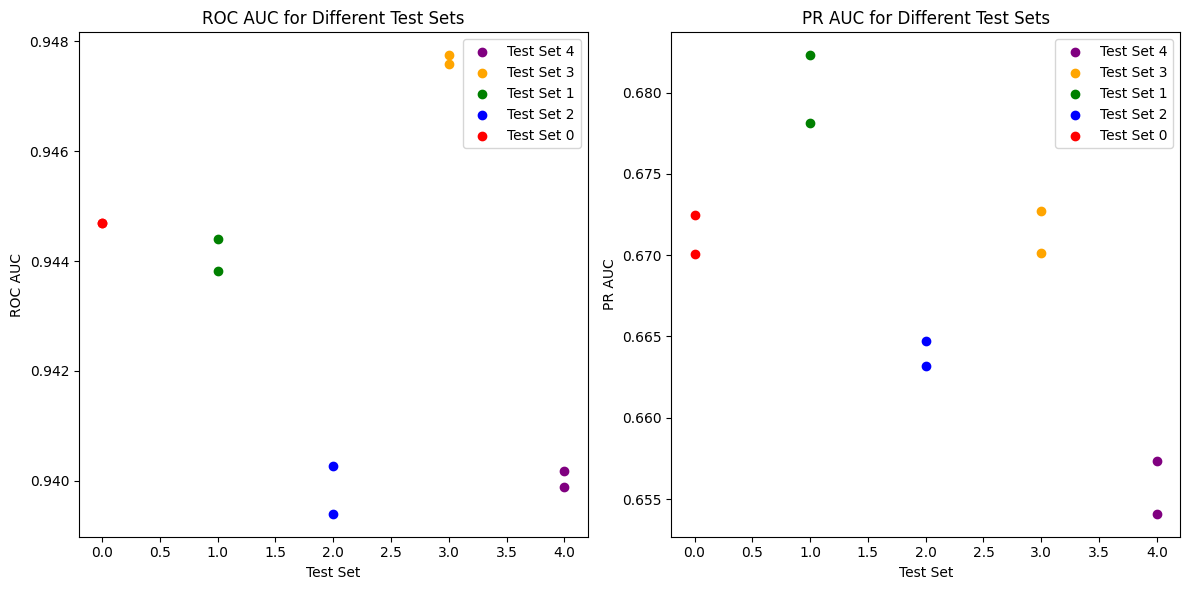

In [1]:
# Data
data = {
    "Test Set": [4, 4, 3, 3, 1, 1, 2, 2, 0, 0],
    "ROC AUC": [0.93988, 0.9401836094, 0.9475872296, 0.9477470426, 0.9438191408, 
                0.9444, 0.940268646, 0.9394, 0.9447, 0.9447],
    "PR AUC": [0.65736, 0.6540913, 0.6701376408, 0.67273, 0.67814, 0.6823, 
               0.6647, 0.6632, 0.6725, 0.6701]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Colors for each test set
colors = ['red', 'green', 'blue', 'orange', 'purple']

# Scatter plot for ROC AUC
for test_set in df['Test Set'].unique():
    subset = df[df['Test Set'] == test_set]
    ax[0].scatter(subset['Test Set'], subset['ROC AUC'], label=f"Test Set {test_set}", color=colors[test_set])

ax[0].set_xlabel('Test Set')
ax[0].set_ylabel('ROC AUC')
ax[0].set_title('ROC AUC for Different Test Sets')
ax[0].legend()

# Scatter plot for PR AUC
for test_set in df['Test Set'].unique():
    subset = df[df['Test Set'] == test_set]
    ax[1].scatter(subset['Test Set'], subset['PR AUC'], label=f"Test Set {test_set}", color=colors[test_set])

ax[1].set_xlabel('Test Set')
ax[1].set_ylabel('PR AUC')
ax[1].set_title('PR AUC for Different Test Sets')
ax[1].legend()

plt.tight_layout()
plt.show()


## Compare Scores pairwise

In [2]:
def z_statistic(m1, m2, s1, s2, n1, n2):
    dm = m1 - m2
    den = np.sqrt(s1**2/n1 + s2**2/n2)
    return dm / den

def calculate_z_statistics(scores, outcomes):
    z_stats = []
    for i in range(len(outcomes)):
        if scores["111"][i] and scores["Baseline 001"][i]:
            z_stat = z_statistic(scores["111"][i][0], scores["Baseline 001"][i][0], scores["111"][i][1], scores["Baseline 001"][i][1], 5, 5)
            z_stats.append(z_stat)
        else:
            z_stats.append(None)
    return z_stats

def create_df_for_score_type(models, outcomes, scores, score_type):
    data = {"Outcome": outcomes}
    for model in models:
        model_scores = scores.get((model, score_type), [None] * len(outcomes))
        data[f"{model} {score_type} Mean"] = [score[0] if score else np.nan for score in model_scores]
        data[f"{model} {score_type} Std"] = [score[1] if score else np.nan for score in model_scores]
    return pd.DataFrame(data)

def cohens_d(m1, m2, s1, s2):
    dm = m1 - m2
    den = np.sqrt((s1**2 + s2**2) / 2)
    return dm / den

# Function to compute and add z-scores to DataFrame
def add_cohensd_to_df(baseline_model, models, outcomes, df, score_type):
    for model in models:
        if model != baseline_model:
            z_scores = []
            for outcome in outcomes:
                m1, s1 = df.loc[df['Outcome'] == outcome, [f"{baseline_model} {score_type} Mean", f"{baseline_model} {score_type} Std"]].values[0]
                m2, s2 = df.loc[df['Outcome'] == outcome, [f"{model} {score_type} Mean", f"{model} {score_type} Std"]].values[0]
                z = cohens_d(m1, m2, s1, s2) if not np.isnan(m1) and not np.isnan(m2) else np.nan
                z_scores.append(z)
            df[f"CD vs {baseline_model} ({model})"] = z_scores
    return df




# Function to plot with error bars
def plot_with_error_bars(df, model1, model2, score_type, outcomes, axis, title):
    # Filter the DataFrame for the specified outcomes
    df_filtered = df[df["Outcome"].isin(outcomes)]

    # Extract means and standard deviations for the filtered outcomes
    means1 = df_filtered[f"{model1} {score_type} Mean"]
    stds1 = df_filtered[f"{model1} {score_type} Std"]
    means2 = df_filtered[f"{model2} {score_type} Mean"]
    stds2 = df_filtered[f"{model2} {score_type} Std"]

    # Extract z-scores
    cds = df_filtered[f"CD vs {model1} ({model2})"]

    # Plot for model1 and model2
    axis.errorbar(outcomes, means1, yerr=stds1, label=model1, capsize=5, fmt='o', linestyle=None)
    axis.errorbar(outcomes, means2, yerr=stds2, label=model2, capsize=5, fmt='o', linestyle=None)

    # Annotate with z-statistics
    for i, (mean, z_stat) in enumerate(zip(means2, cds)):
        if not np.isnan(z_stat):
            axis.annotate(f"CD={z_stat:.2f}", (i, mean), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)
    
    axis.set_xticks(range(len(outcomes)))
    axis.set_xticklabels(outcomes, rotation=45)
    axis.set_title(title)
    axis.legend()

In [12]:
# Data
outcomes = ["Death (1y)", "Pain (1m)", "Breast Cancer (3m)", 
            "Cancer Any (1y)", "Circulatory (1y)", "Diarrhea (30d)", 
            "Basal Cell Carcinoma (1y)", 
            ]
# PR and ROC scores with standard deviations

scores = {
    ("Baseline 001 diag", "PR"):
        [(.6598, .0040), (.785829, .00126), (.10285, .00620),
        None, None, None, 
        None],
    ("001", "PR"): 
        [(.6794, .0025), (.79198, .00083), (.10488, .00594),
        None, None, None, 
        None],
    ("111", "PR"): 
        [None, None, None,
        None, None, None, 
        None],
    ("000", "PR"): 
        [None, None, None, 
        None,None, None, 
        None, ],
    ("Baseline 001 diag", "ROC"):
        [(.94069, .00072), (.76678, .00085), (.78870, .00563),
        None, None, None, 
        None],
    ("001", "ROC"): 
        [(.94342, .00039), (.77136, .00023), (.80276, .00247), 
        None,None, None, 
        None,],
    ("111", "ROC"): 
        [None, None, None, 
        None, None, None, 
        None,],
    ("000", "ROC"): 
        [None, None, None, 
        None,None, None, 
        None,],
    ("001_10", "PR"): 
        [None, None, None, 
        None,None, None, 
        None,],
    ("001_10", "ROC"): 
        [None, None, None, 
        None,None, None, 
        None,]

}   
models = [model for model, score_type in scores.keys()]
df_pr = create_df_for_score_type(models, outcomes, scores, "PR")
df_roc = create_df_for_score_type(models, outcomes, scores, "ROC")
df_pr = add_cohensd_to_df("Baseline 001 diag", models, outcomes, df_pr, "PR")
df_roc = add_cohensd_to_df("Baseline 001 diag", models, outcomes, df_roc, "ROC")

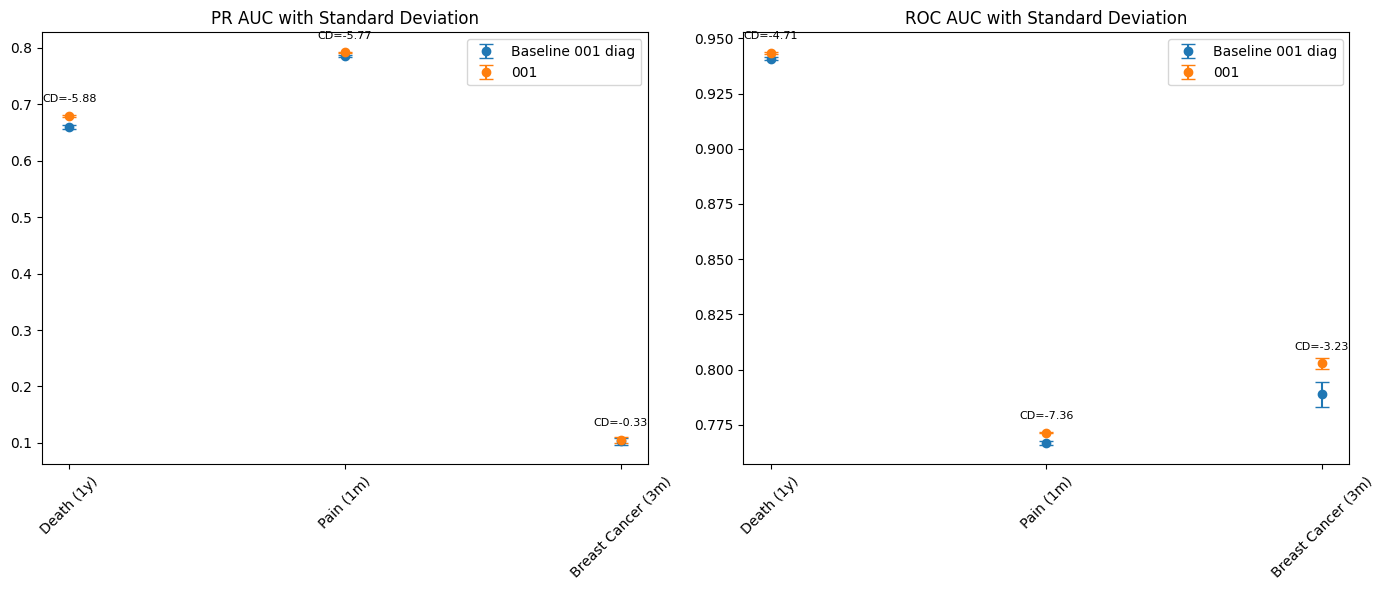

In [14]:
# Plotting
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
# PR AUC plot
show_outcomes = ["Death (1y)", "Pain (1m)", "Breast Cancer (3m)"] # order matters
plot_with_error_bars(df_pr, "Baseline 001 diag", "001", "PR", show_outcomes, 
                     ax[0], "PR AUC with Standard Deviation")
plot_with_error_bars(df_roc, "Baseline 001 diag", "001", "ROC", show_outcomes, 
                     ax[1], "ROC AUC with Standard Deviation")

plt.tight_layout()
plt.show()
#fig.savefig("../results/initial_pt_experiments/pr_roc_auc_baseline_vs_111.png", dpi=300)


KeyError: 'Baseline 001 PR Mean'

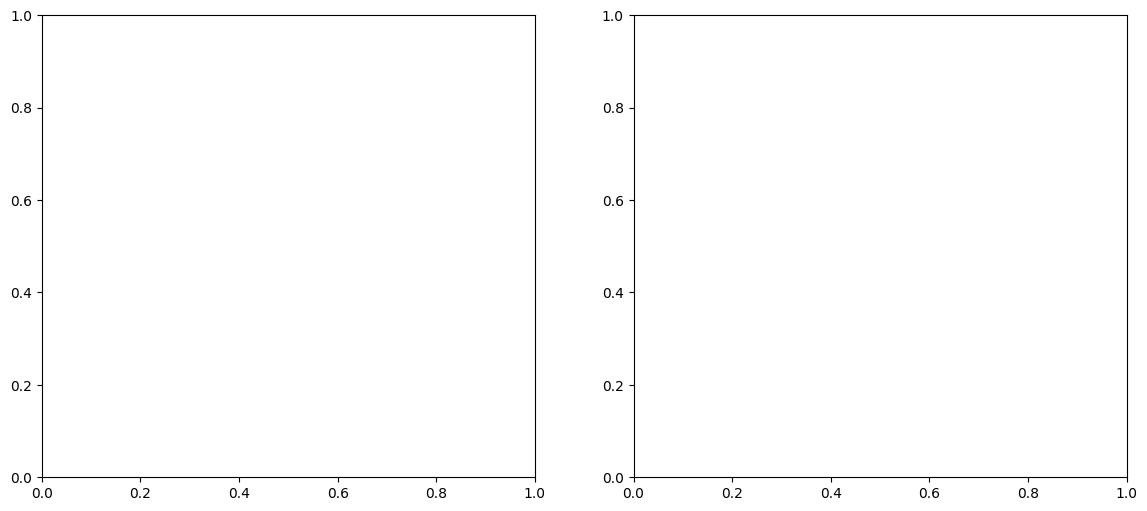

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# PR AUC plot
plot_with_error_bars(df_pr, "Baseline 001", "000", "PR", ['Death (1y)', 'Pain (1m)'], 
                     ax[0], "PR AUC with Standard Deviation")
plot_with_error_bars(df_roc, "Baseline 001", "000", "ROC", ['Death (1y)', 'Pain (1m)'], 
                     ax[1], "ROC AUC with Standard Deviation")

plt.tight_layout()
plt.show()
fig.savefig("../results/initial_pt_experiments/pr_roc_auc_baseline_vs_no_sep.png", dpi=300)


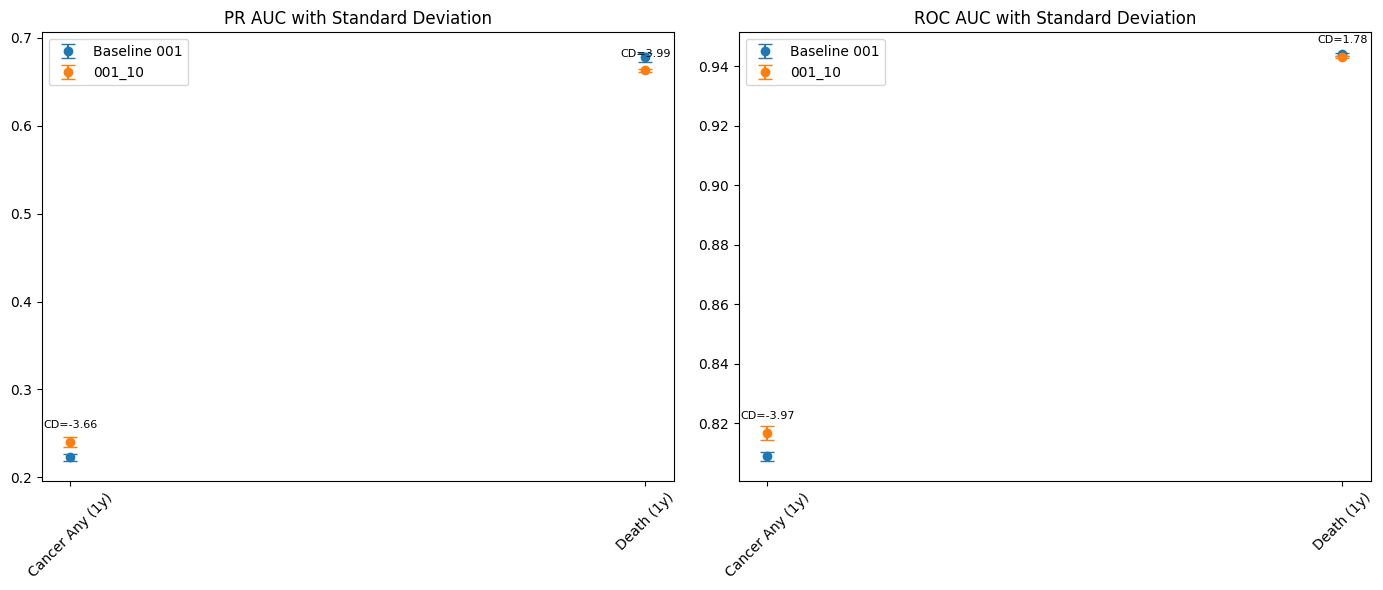

In [56]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# PR AUC plot
plot_with_error_bars(df_pr, "Baseline 001", "001_10", "PR", ['Cancer Any (1y)', 'Death (1y)'], 
                     ax[0], "PR AUC with Standard Deviation")
plot_with_error_bars(df_roc, "Baseline 001", "001_10", "ROC", ['Cancer Any (1y)', 'Death (1y)'], 
                     ax[1], "ROC AUC with Standard Deviation")

plt.tight_layout()
plt.show()
fig.savefig("../results/initial_pt_experiments/pr_roc_auc_baseline_vs_our_embeddings.png", dpi=300)

In [67]:
old_test_pids = r"C:\Users\fjn197\PhD\projects\PHAIR\pipelines\ehr2vec\ehr2vec\ehr2vec\outputs\pretraining\behrt_test\finetune_TEST_OUTCOME_censored_4_days_post_TEST_OUTCOME_test\test_pids.pt"

In [69]:
new_test_pids = r"C:\Users\fjn197\PhD\projects\PHAIR\pipelines\ehr2vec\ehr2vec\ehr2vec\outputs\pretraining\behrt_test_2\finetune_TEST_OUTCOME_censored_4_days_post_TEST_OUTCOME_test\test_pids.pt"

In [71]:
set(old_test_pids)== set(new_test_pids)

True